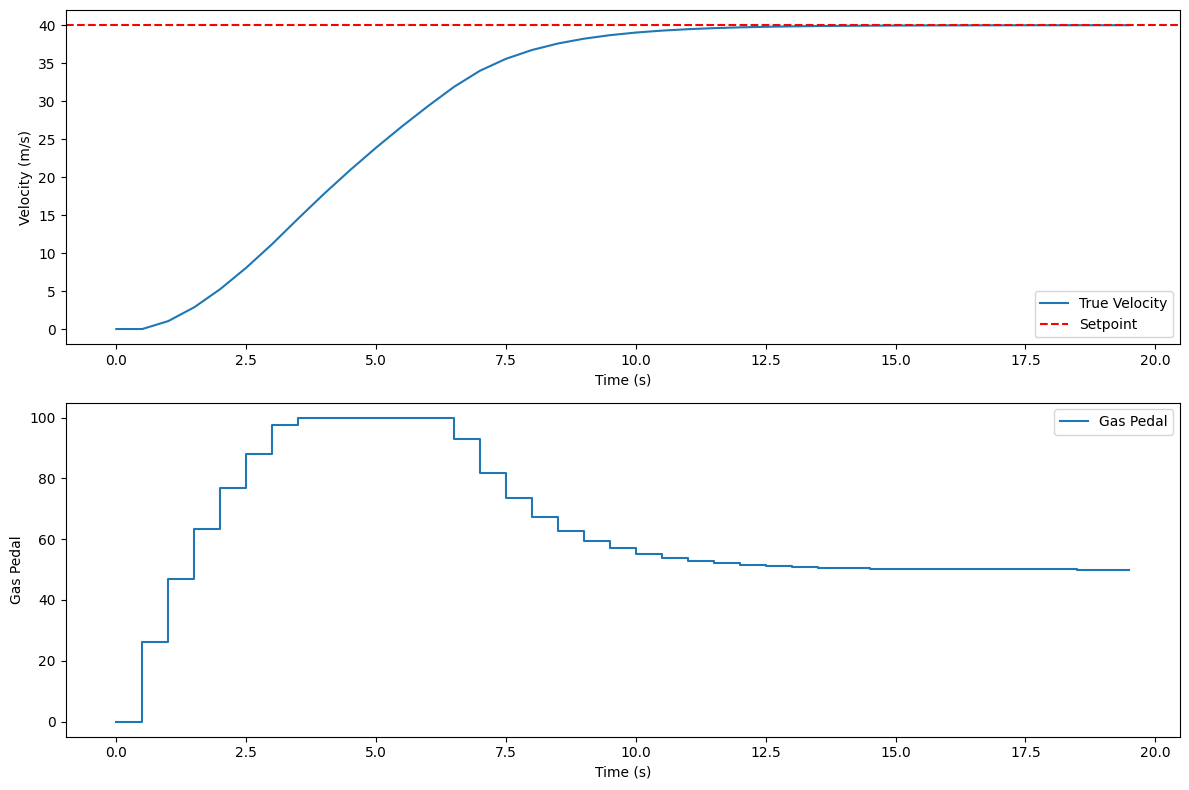

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Constants
mass = 500  # Vehicle mass
b = 50  # Damping coefficient
K = 0.8  # Gain
SP = 40  # Setpoint velocity
dt = 0.5
time = np.arange(0, 20, dt)

# Parameters for smoothing and limiting gas pedal changes
DCOST = 0.1  # Penalize large changes in gas pedal movement

# Model to update velocity
def model(v_k, p_k):
    return v_k + (K * b * p_k - b * v_k) * dt / mass

# Cost function
def cost_function(p_sequence, v_initial, t):
    v_pred = v_initial
    J = 0.0
    SP_dynamic = np.clip(t / 5 * SP, 0, SP)  # Gradual ramp of setpoint
    for j in range(Np):
        p = p_sequence[min(j, Nc - 1)]
        v_pred = model(v_pred, p)
        if j > 0:
            J += (v_pred - SP_dynamic) ** 2 + DCOST * (p - p_sequence[j - 1]) ** 2
        else:
            J += (v_pred - SP_dynamic) ** 2
    return J

# MPC function
def mpc_control(v, t):
    p_initial = np.linspace(0, 50, Np)  # Gradual ramp for initial guess
    result = minimize(cost_function, p_initial, args=(v, t), bounds=[(0, 100)] * Np)
    return result.x[0] if result.success else 0.0

# Simulation setup
v = 0
Np = 10
Nc = 5
velocities = []
controls = []

for t in range(len(time)):
    p_opt = mpc_control(v, t * dt)
    velocities.append(v)
    controls.append(p_opt)
    v = model(v, p_opt)

# Dataframe with results
df = pd.DataFrame({'Time (s)': time, 'Gas Pedal': controls, 'Velocity (m/s)': velocities})

# Plotting
plt.figure(figsize=(12, 8))

# Velocity plot
plt.subplot(2, 1, 1)
plt.plot(time, velocities, label='True Velocity')
plt.axhline(y=SP, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

# Control action plot
plt.subplot(2, 1, 2)
plt.step(time, controls, where='post', label='Gas Pedal')
plt.xlabel('Time (s)')
plt.ylabel('Gas Pedal')
plt.legend()
plt.tight_layout()
plt.show()


### Use black-box ML as model

In [2]:
import torch
import torch.nn as nn

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def np_to_ts(x):
    return torch.tensor(x, dtype=torch.float32, requires_grad=True).view(-1, 1).to(DEVICE)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

In [12]:
def generate_data(num_samples: int = 1000):
    # Generate data for training
    df = pd.DataFrame(columns=['Time (s)', 'Gas Pedal', 'Velocity (m/s)'])
    df['Velocity (m/s)'] = np.random.uniform(0.0, 40.0, num_samples)
    df['Gas Pedal'] = np.random.uniform(0.0, 100.0, num_samples)
    df['Time (s)'] = 0.0
    return df

def generate_collocation_data(num_samples: int = 1000):
    df = pd.DataFrame(columns=['Time (s)', 'Gas Pedal', 'Velocity (m/s)'])
    df['Velocity (m/s)'] = np.random.uniform(0.0, 40.0, num_samples)
    df['Gas Pedal'] = np.random.uniform(0.0, 100.0, num_samples)
    df['Time (s)'] = np.random.uniform(0.0, 20.0, num_samples)
    return df

In [18]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [19]:
def loss_fn(net: PINN):
    df_col = generate_collocation_data(num_samples=10000)
    t_col = np_to_ts(df_col["Time (s)"].values).to(DEVICE)
    v_col = np_to_ts(df_col["Velocity (m/s)"].values).to(DEVICE)
    p_col = np_to_ts(df_col["Gas Pedal"].values).to(DEVICE)
    X_col = torch.cat((t_col, v_col, p_col), 1).to(DEVICE)
    preds = net.forward(X_col)
    v_pred = preds
    dvdt = grad(v_pred, t_col)[0]
    error_ode = nn.MSELoss()(dvdt, 1/mass * (-v_pred * b + K * b + p_col))
    return error_ode

In [20]:
train_df = generate_data(num_samples=1000)
t_train = np_to_ts(train_df["Time (s)"].values).to(DEVICE)
v_train = np_to_ts(train_df["Velocity (m/s)"].values).to(DEVICE)
p_train = np_to_ts(train_df["Gas Pedal"].values).to(DEVICE)
X_train = torch.cat((t_train, v_train, p_train), 1).to(DEVICE)
y_train = np_to_ts(train_df["Velocity (m/s)"].values).to(DEVICE)

net = PINN(3, 1).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = net.forward(X_train)
    loss_data = nn.MSELoss()(preds, y_train)
    loss_ode = loss_fn(net)
    loss = loss_data + loss_ode
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss_data: {loss_data.item():.4f}, Loss_ode: {loss_ode.item():.4f}")
        

Epoch 0, Loss_data: 500.7903, Loss_ode: 0.0312
Epoch 100, Loss_data: 198.7433, Loss_ode: 0.6367
Epoch 200, Loss_data: 115.0351, Loss_ode: 0.6894
Epoch 300, Loss_data: 64.1574, Loss_ode: 0.2916
Epoch 400, Loss_data: 36.4053, Loss_ode: 0.1958
Epoch 500, Loss_data: 21.7495, Loss_ode: 0.1362
Epoch 600, Loss_data: 13.4507, Loss_ode: 0.1122
Epoch 700, Loss_data: 8.5397, Loss_ode: 0.0779
Epoch 800, Loss_data: 5.5599, Loss_ode: 0.0616
Epoch 900, Loss_data: 3.7012, Loss_ode: 0.0644
Epoch 1000, Loss_data: 2.5188, Loss_ode: 0.0557
Epoch 1100, Loss_data: 1.7475, Loss_ode: 0.0308
Epoch 1200, Loss_data: 1.3813, Loss_ode: 0.0355
Epoch 1300, Loss_data: 0.8742, Loss_ode: 0.0236
Epoch 1400, Loss_data: 0.6296, Loss_ode: 0.0178
Epoch 1500, Loss_data: 0.4597, Loss_ode: 0.0152
Epoch 1600, Loss_data: 0.3390, Loss_ode: 0.0140
Epoch 1700, Loss_data: 0.2508, Loss_ode: 0.0111
Epoch 1800, Loss_data: 0.1921, Loss_ode: 0.0128
Epoch 1900, Loss_data: 0.1870, Loss_ode: 0.0075
Epoch 2000, Loss_data: 0.1415, Loss_ode: 0

In [21]:
T_s = dt
t_test = time.copy()
v_test = velocities.copy()
p_test = controls.copy()

v_0 = v_test[0]
p_0 = p_test[0]
v_preds = []
for t in range(1, len(t_test)):
    v_k = net.forward(
        torch.tensor([T_s, v_0, p_0], dtype=torch.float32).view(1, -1).to(DEVICE)   
    )
    v_0 = v_test[t]
    p_0 = p_test[t]
    v_preds.append(v_k.item())

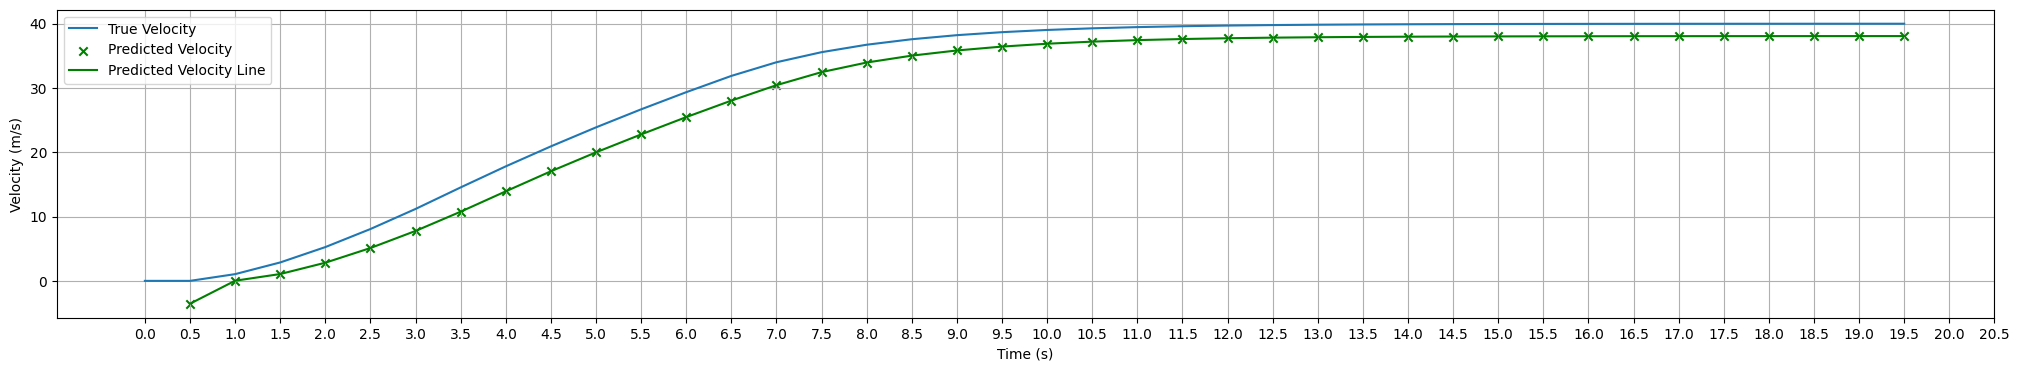

In [22]:
# Plot the results
plt.figure(figsize=(25, 4))
plt.plot(time, velocities, label='True Velocity')
plt.scatter(time[1:], v_preds, color='green', marker='x', label='Predicted Velocity')
plt.plot(time[1:], v_preds, color='green', linestyle='-', label='Predicted Velocity Line')
plt.xticks(np.arange(0, 21, dt))
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()